# Send Python code execution to a remote SQL Server from Jupyter Notebooks
Did you know that you can execute R and Python code remotely in SQL Server? This Tutorial will show you how you can send your python code from Juptyter notebooks to execute within SQL Server. 

Instead of transferring large and sensitive data over the network or losing accuracy with sample csv files, you can have your R/Python code execute within your database. Train and store machine learning models in your database bringing intelligence to where your data lives. 

<img src="files/images/RemoteCompute.png">

## Prerequisites
1. In order for R or Python to execute within SQL, you need the Machine Learning Services feature installed and configured. See this how-to guide:  https://blogs.msdn.microsoft.com/mlserver/2018/05/18/getting-started-with-machine-learning-services-in-sql-server/
2. In order to send Python execution to SQL, you need to use Microsoft's RevoscalePy package. To get revoscalepy, download and install Microsoft's Python Client:
https://docs.microsoft.com/en-us/machine-learning-server/install/python-libraries-interpreter

# Database Setup
This is a one time setup step to ensure you have the same data for this tutorial. You won't need to perform any of these steps to use your own data.
### 1. Create a database

In [3]:
import pyodbc

# creating a new db to load Iris sample in
new_db_name = "MLRemoteExec"
connection_string = "Driver=SQL Server;Server=localhost\MSSQLSERVER2017;Database={0};Trusted_Connection=Yes;" 
                        # you can also swap Trusted_Connection for UID={your username};PWD={your password}
cnxn = pyodbc.connect(connection_string.format("master"), autocommit=True)
cnxn.cursor().execute("IF EXISTS(SELECT * FROM sys.databases WHERE [name] = '{0}') DROP DATABASE {0}".format(new_db_name))
cnxn.cursor().execute("CREATE DATABASE " + new_db_name)
cnxn.close()

print("Database created")

Database created


### 2. Import Iris sample from Sklearn

In [4]:
from sklearn import datasets
import pandas as pd

# SkLearn has the Iris sample dataset built in to the package
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

### 3. Use <a href="https://docs.microsoft.com/en-us/machine-learning-server/python-reference/revoscalepy/revoscalepy-package" target="_blank">RevoscalePy APIs</a> to create a table and load the Iris data
(You can also do this with pyodbc, sqlalchemy or other packages)

In [5]:
from revoscalepy import RxSqlServerData, rx_data_step

# Example of using RX APIs to load data into SQL table. You can also do this with pyodbc
table_ref = RxSqlServerData(connection_string=connection_string.format(new_db_name), table="Iris")
rx_data_step(input_data = df, output_file = table_ref, overwrite = True)

print("New Table Created: Iris")
print("Sklearn Iris sample loaded into Iris table")

Rows Read: 150, Total Rows Processed: 150
Total Rows written: 150, Total time: 0.015
, Total Chunk Time: 0.047 seconds 
New Table Created: Iris
Sklearn Iris sample loaded into Iris table


# Define function to send to SQL Server
Write any python code you want to execute in SQL. In this example we are creating a scatter matrix on the iris dataset and returning the bytestream of the .png back to Jupyter Notebooks to render on our client.

In [6]:
def send_this_func_to_sql():
    from revoscalepy import RxSqlServerData, rx_import
    from pandas.tools.plotting import scatter_matrix
    import matplotlib.pyplot as plt
    import io
    
    # remember the scope of the variables in this func are within our SQL Server Python Runtime
    connection_string = "Driver=SQL Server;Server=localhost\MSSQLSERVER2017;Database=MLRemoteExec;Trusted_Connection=Yes;"
    
    # specify a query and load into pandas dataframe df
    sql_query = RxSqlServerData(connection_string=connection_string, sql_query = "select * from Iris")
    df = rx_import(sql_query)
    
    scatter_matrix(df)
    
    # return bytestream of image created by scatter_matrix
    buf = io.BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    
    return buf.getvalue()

# Send execution to SQL
Now that we are set up, check out how easy this really is. Import revoscalepy, Create a sql compute context, and then send the execution of any function seamlessly to SQL Server with RxExec.

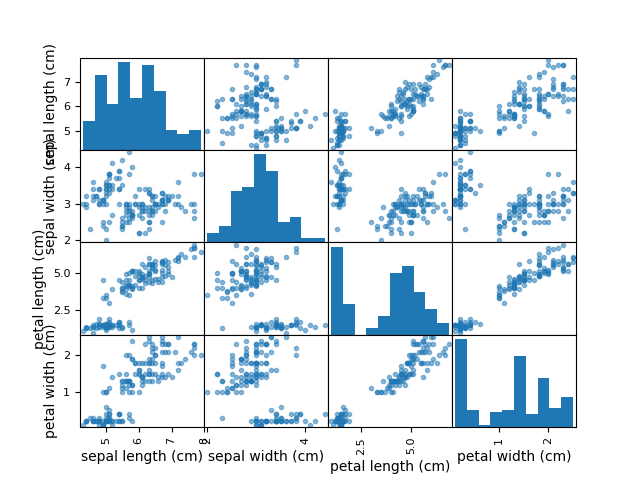

In [7]:
from IPython import display
import matplotlib.pyplot as plt 
from revoscalepy import RxInSqlServer, rx_exec

# create a remote compute context with connection to SQL Server
sql_compute_context = RxInSqlServer(connection_string=connection_string.format(new_db_name))

# use rx_exec to send the function execution to SQL Server
image = rx_exec(send_this_func_to_sql, compute_context=sql_compute_context)[0]

# only an image was returned to my jupyter client. All data remained secure and was manipulated in my db.
display.Image(data=image)